In [ ]:
# camera calibration and distortion

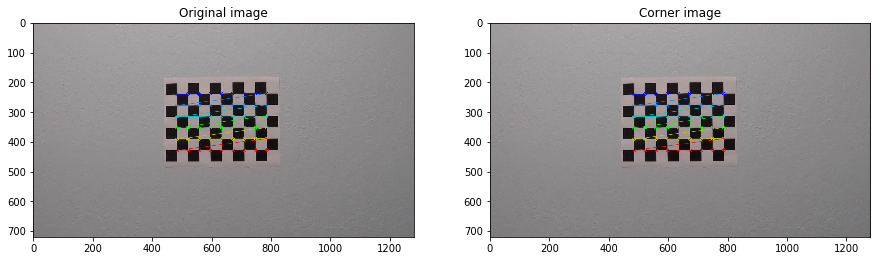

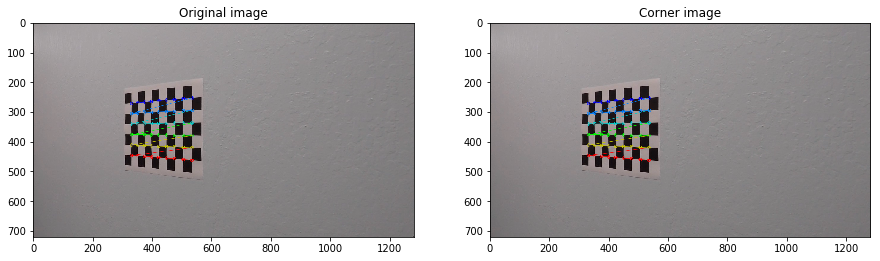

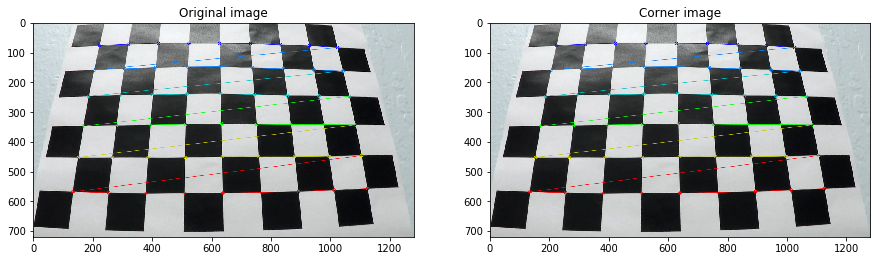

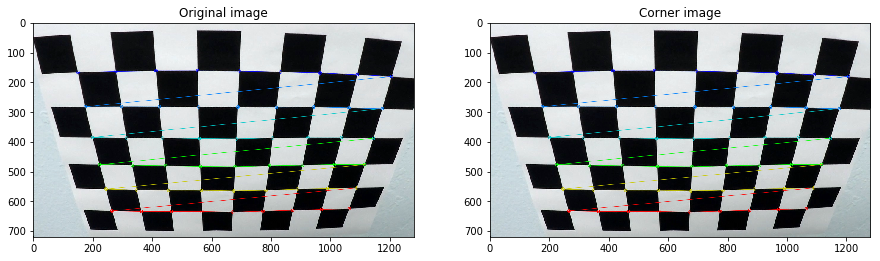

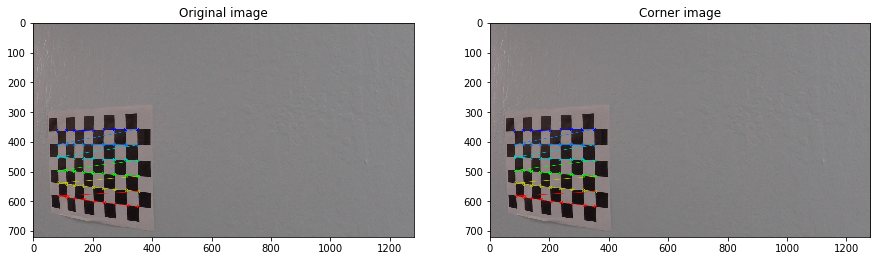

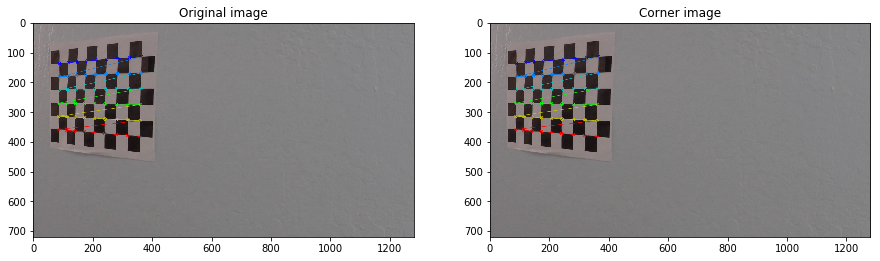

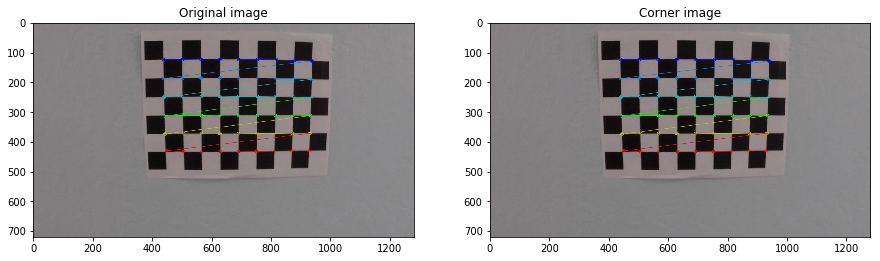

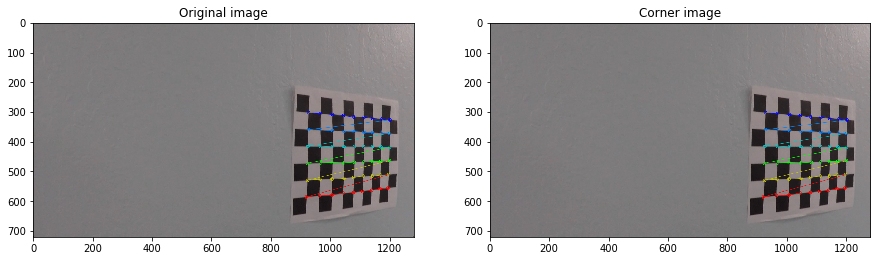

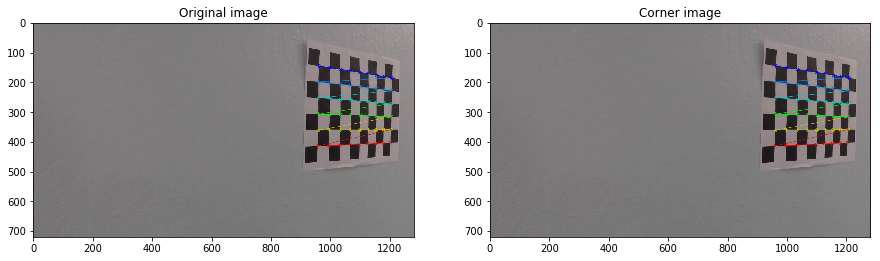

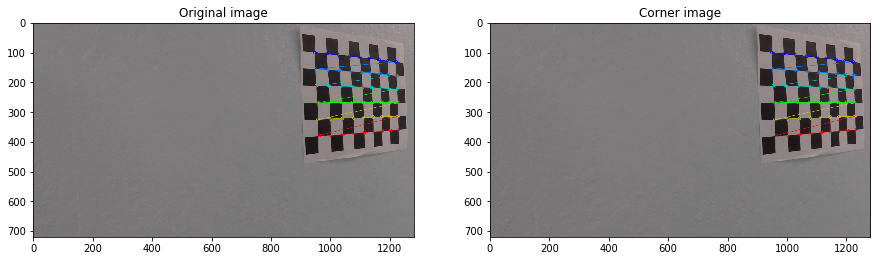

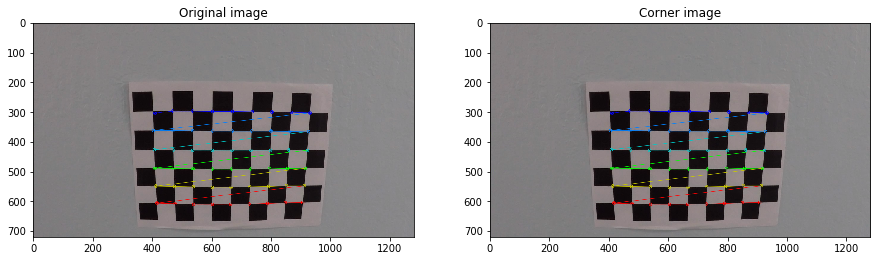

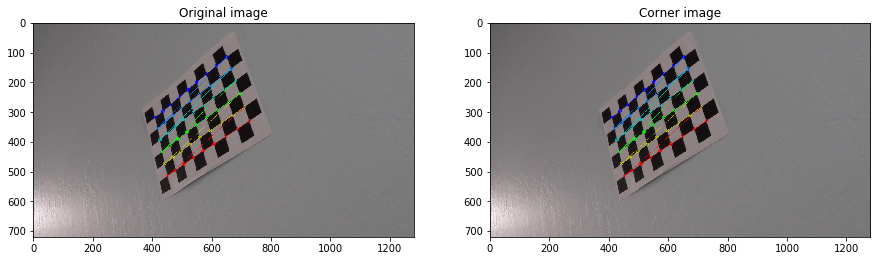

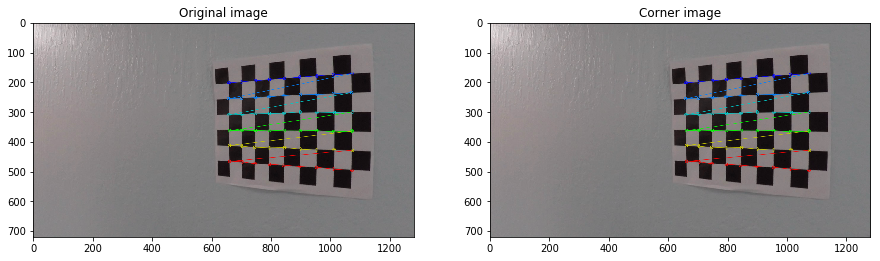

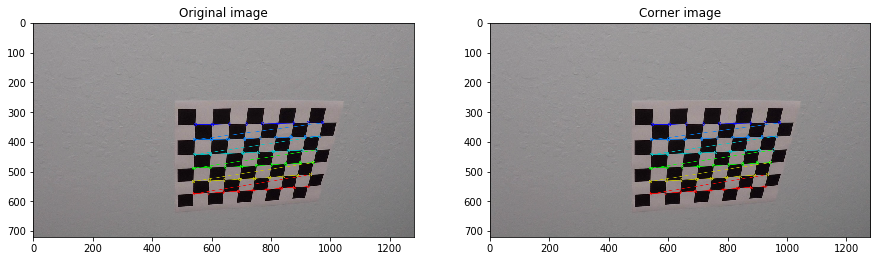

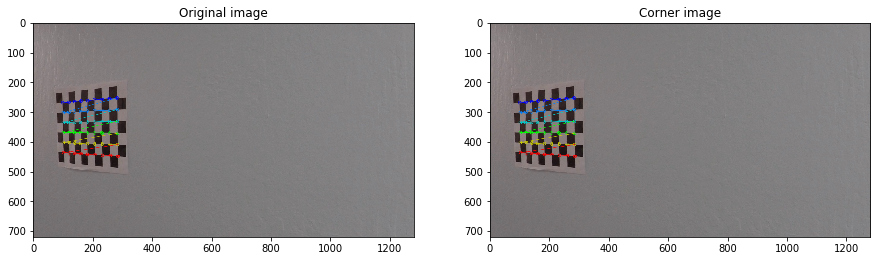

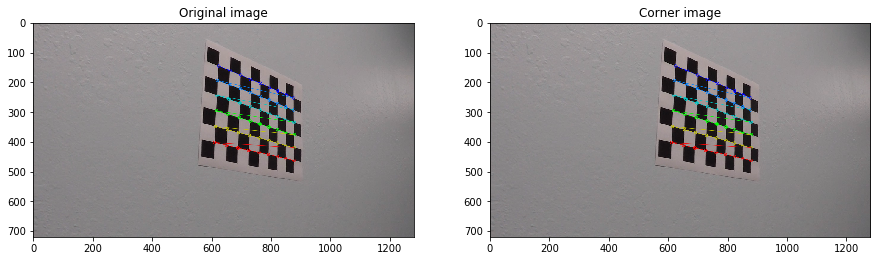

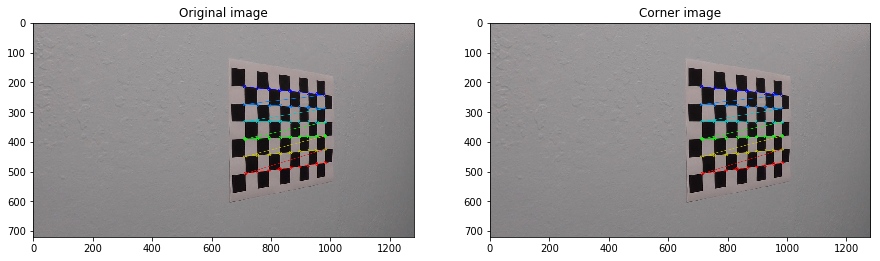

In [5]:
# Camera Calibration matrix and distortion coefiicients 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Arrays to store object points and image points from all the images
objPoints = []
imgPoints = []
 
# prepare object points 
objP = np.zeros((6*9,3), np.float32)
objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

imgContainer = glob.glob('camera_cal/*.jpg')


testImage = cv2.imread('./test_images/test2.jpg')
testCameraImg = cv2.imread('./camera_cal/calibration01.jpg')
for i, index in enumerate(imgContainer):
    image = cv2.imread(index)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objP)
        f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15,11))
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        axs1.set_title("Original image")
        axs1.imshow(image)
        axs2.set_title("Corner image")
        axs2.imshow(img)


In [6]:
# these individual implementation steps are being followed from the lectures series
# undistortion

def singleUndistort(image):
    img_shape = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, img_shape, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,11))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image')
    """
    return undist


In [ ]:
images = glob.glob('./camera_cal/*.jpg')
for image in images:
    image = cv2.imread(image)
    singleUndistort(image)

In [7]:
# test distortion on a single image

img_size = (testCameraImg.shape[1], testCameraImg.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(testCameraImg, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testCameraImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# Perspective Transform
# define both source and destination points to get the perspective transform and
# then creare the wraped image

def singlePerspectiveTransform(img):
    undst = singleUndistort(img)
    imgSize = (undst.shape[1], undst.shape[0])
    srcPoints = np.float32([[500, 480],[790, 480],[1250, 720],[220, 720]])
    dstPoints = np.float32([[0, 0], [1250,0], [1250,720 ],[220,720]])
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    warped = cv2.warpPerspective(undst, M, imgSize)
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 11))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(undst, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image')
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted and Warped Image')
    """
    return warped, M


In [ ]:
images = glob.glob('./test_images/test*.jpg')

for image in images:
    img = cv2.imread(image)
    singlePerspectiveTransform(img)
    

In [ ]:
# Color thresholds

def colorThreshold(image):
    img, M = singlePerspectiveTransform(image)
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    thresh = (180,255)
    sxbinary = np.zeros_like(s_channel)
    sxbinary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    thresh = (150,200)
    bxbinary = np.zeros_like(b_channel)
    bxbinary[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    
    thresh = (225,255)
    lxbinary = np.zeros_like(l_channel)
    lxbinary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    
    combinedBinary = np.zeros_like(sxbinary)
    combinedBinary[(sxbinary == 1) | (bxbinary == 1)] = 1
    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 11))
    f.tight_layout()
    ax1.set_title("Original image")
    ax1.imshow(image)
    ax2.set_title("bird's eye")
    ax2.imshow(img)
    ax3.imshow(sxbinary, cmap='gray')
    ax3.set_title('Undistorted Image')
    ax4.imshow(combinedBinary, cmap='gray')
    ax4.set_title('Undistorted and Warped Image')
    
    
    return combinedBinary
    

In [ ]:
images = glob.glob('./test_images/test*.jpg')
for image in images:
    img = cv2.imread(image)
    colorThreshold(img)

In [ ]:
def single_sobel_thresh(imgContainer, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(imgContainer, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15, 11))
    f.tight_layout()
    axs1.set_title("Original Image")
    axs1.imshow(imgContainer)
    axs2.set_title("Sobel Image")
    axs2.imshow(sxbinary, cmap='gray')

    return sxbinary

In [ ]:
# testing the sobel output
thresh = (25,255)
ind = single_sobel_thresh(img, orient='x', thresh=(35,255))
unwarp = singlePerspectiveTransform(ind)[:,:,2]
plt.imshow(unwarp)

In [ ]:
# magnitude threshold
def single_mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output



# Applying the magnitude threshold to a single image or to apply it in a pipeline
image = cv2.imread('./test_images/test1.jpg')
image = single_mag_thresh(image, sobel_kernel=25, thresh=(25,255))
plt.imshow(image, cmap='gray')

In [ ]:
# direction gradient
# magnitude threshold
def single_dir_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    absX = np.absolute(sobelx)
    absY = np.absolute(sobely)
    angle = np.arctan2(absY,absX)
    binary_output = np.zeros_like(absY)
    binary_output[(angle >= thresh[0]) & (angle <= thresh[1])] = 1
    return binary_output



# Applying the magnitude threshold to a single image or to apply it in a pipeline
image = cv2.imread('./test_images/test1.jpg')
image = single_dir_thresh(image, sobel_kernel=25, thresh=(0.7,1.3))
plt.imshow(image, cmap='gray')



In [ ]:
# combining the thresholds

def pipeline(images):
    for image in images:
        image = cv2.imread(image)
        
        gradx = single_sobel_thresh(image, orient='x', thresh=(10,220))
        #grady = single_abs_sobel_thresh(image, orient='y', thresh=(60,255))
        mag_binary = single_mag_thresh(image, sobel_kernel=ksize, thresh=(40, 255))
        dir_binary = single_dir_thresh(image, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))
        combined = np.zeros_like(dir_binary)
        #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        f, (axs1, axs2) = plt.subplots(1, 2, figsize=(15, 11))
        f.tight_layout()
        axs1.set_title("Original Image")
        axs1.imshow(image)
        axs2.set_title("Combined Image")
        axs2.imshow(combined, cmap='gray')
        """
        # applying the color threshold
        color_thresh = (180,255)
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        binaryS = np.zeros_like(S)
        binaryS[(S > color_thresh[0]) & (S <= color_thresh[1])] = 1
        
        
        color_thresh = (15,100)
        binaryH = np.zeros_like(H)
        binaryH[(H > color_thresh[0]) & (H <= color_thresh[1])] = 1

        color_thresh = (65,255)
        binaryL = np.zeros_like(L)
        binaryL[(L > color_thresh[0]) & (L <= color_thresh[1])] = 1
        
        #
        f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(15, 11))
        f.tight_layout()
        
        axs1.set_title("Original Image")
        axs1.imshow(image)

        axs2.set_title("S channel Image")
        axs2.imshow(binaryS, cmap='gray')

        axs3.set_title("H channel Image")
        axs3.imshow(binaryH, cmap='gray')

        axs4.set_title("L channel Image")
        axs4.imshow(binaryL, cmap='gray')
        """
        
    return combined
        
        
ksize = 31
images = glob.glob('./test_images/*.jpg')
imgContainer = pipeline(images)




In [ ]:
# apply perspective transform
image = singlePerspectiveTransform(imgContainer)
plt.imshow(image)
